In [22]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cv2 
from sklearn import mixture
from scipy import linalg
import itertools
# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import widgets as wd

analysis = False
save = True

In [2]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [3]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [5]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength_ini = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

variables.path = os.path.join(p, 'tests//results//reconstruction')
variables.result_path = os.path.join(p, 'tests/results/ml/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


In [6]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp,mc (Da),element,color,rx (nm),ry (nm),rz (nm)
0,5216.226562,5216.226562,1572.0,633.384306,-0.031837,0.859592,0.0,1.0,27.713360,0,0,-0.027809,0.750848,0.004120
1,5216.226562,5216.226562,1791.0,628.981470,-0.350204,-18.720000,219.0,1.0,27.003132,Al27(1+),#2c0359,-0.299869,-16.029368,1.898736
2,5216.226562,5216.226562,1992.0,635.510286,-11.906939,2.610612,201.0,1.0,27.493455,0,0,-10.312656,2.261064,0.816889
3,5216.226562,5216.226562,2429.0,624.222018,7.195102,-0.827755,437.0,1.0,26.965459,Al27(1+),#2c0359,6.266145,-0.720884,0.290471
4,5216.226562,5216.226562,3220.0,629.276364,14.644898,7.449796,791.0,1.0,27.027015,Al27(1+),#2c0359,12.596940,6.408009,1.470937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858635,5711.025879,5711.025879,3626.0,601.419168,-4.998367,-1.846531,152.0,1.0,26.985305,Al27(1+),#2c0359,-4.772563,-1.763112,NaN
1858636,5711.025879,5711.025879,3641.0,602.674182,-0.827755,-14.867755,15.0,1.0,26.971058,Al27(1+),#2c0359,-0.781670,-14.039988,NaN
1858637,5711.025879,5711.025879,4538.0,600.644214,-6.271837,3.565714,897.0,1.0,26.801420,Al27(1+),#2c0359,-5.980342,3.399992,NaN
1858638,5711.025879,5711.025879,5881.0,459.993492,34.097143,5.380408,1343.0,1.0,13.680422,0,0,30.546395,4.820113,NaN


In [7]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
dld_x = data['x (mm)'].to_numpy()
dld_y = data['y (mm)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
mc = data['mc (Da)'].to_numpy()

11-07-2022 14:54:40 | INFO | Selected Mode = count
11-07-2022 14:54:40 | INFO | Selected Mode = count
11-07-2022 14:54:40 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


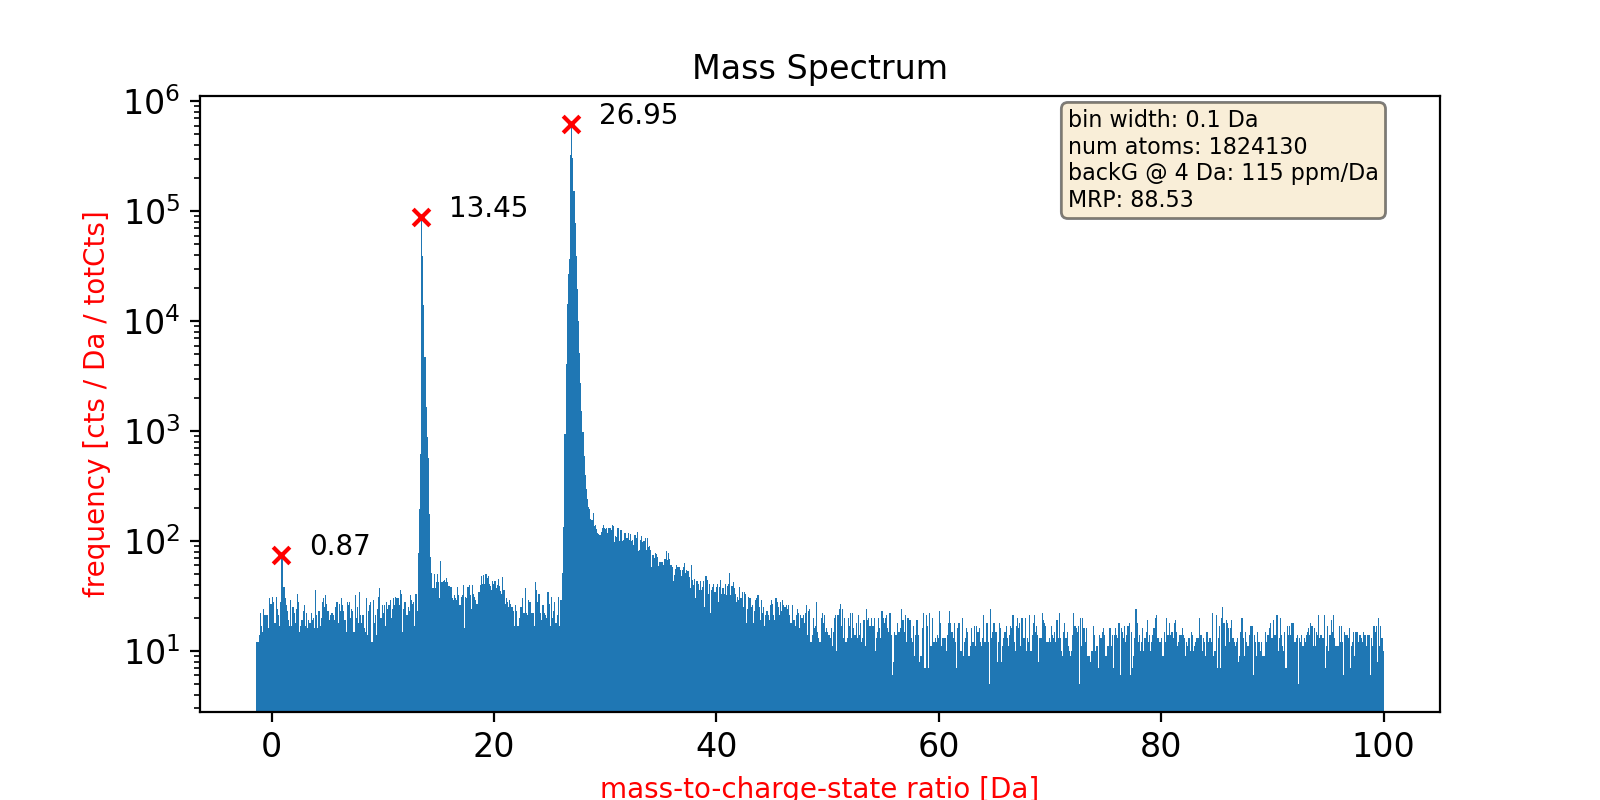

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [88.52749516]
Peaks  0 is: 0.87 peak window sides are: 0.77 - 1.18
Peaks  1 is: 13.45 peak window sides are: 13.35 - 13.55
Peaks  2 is: 26.95 peak window sides are: 26.74 - 27.05


In [8]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc[mc < 100], 0.1, prominence=40, distance=2, text_loc='right', percent=50, plot=True, fig_name='mc'+figname, peaks_find_plot=True)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
peak_list = []
for i in range(len(peaks_sides_p)):
    peak_list.append(peaks_sides_p[i,0])
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

<IPython.core.display.Javascript object>


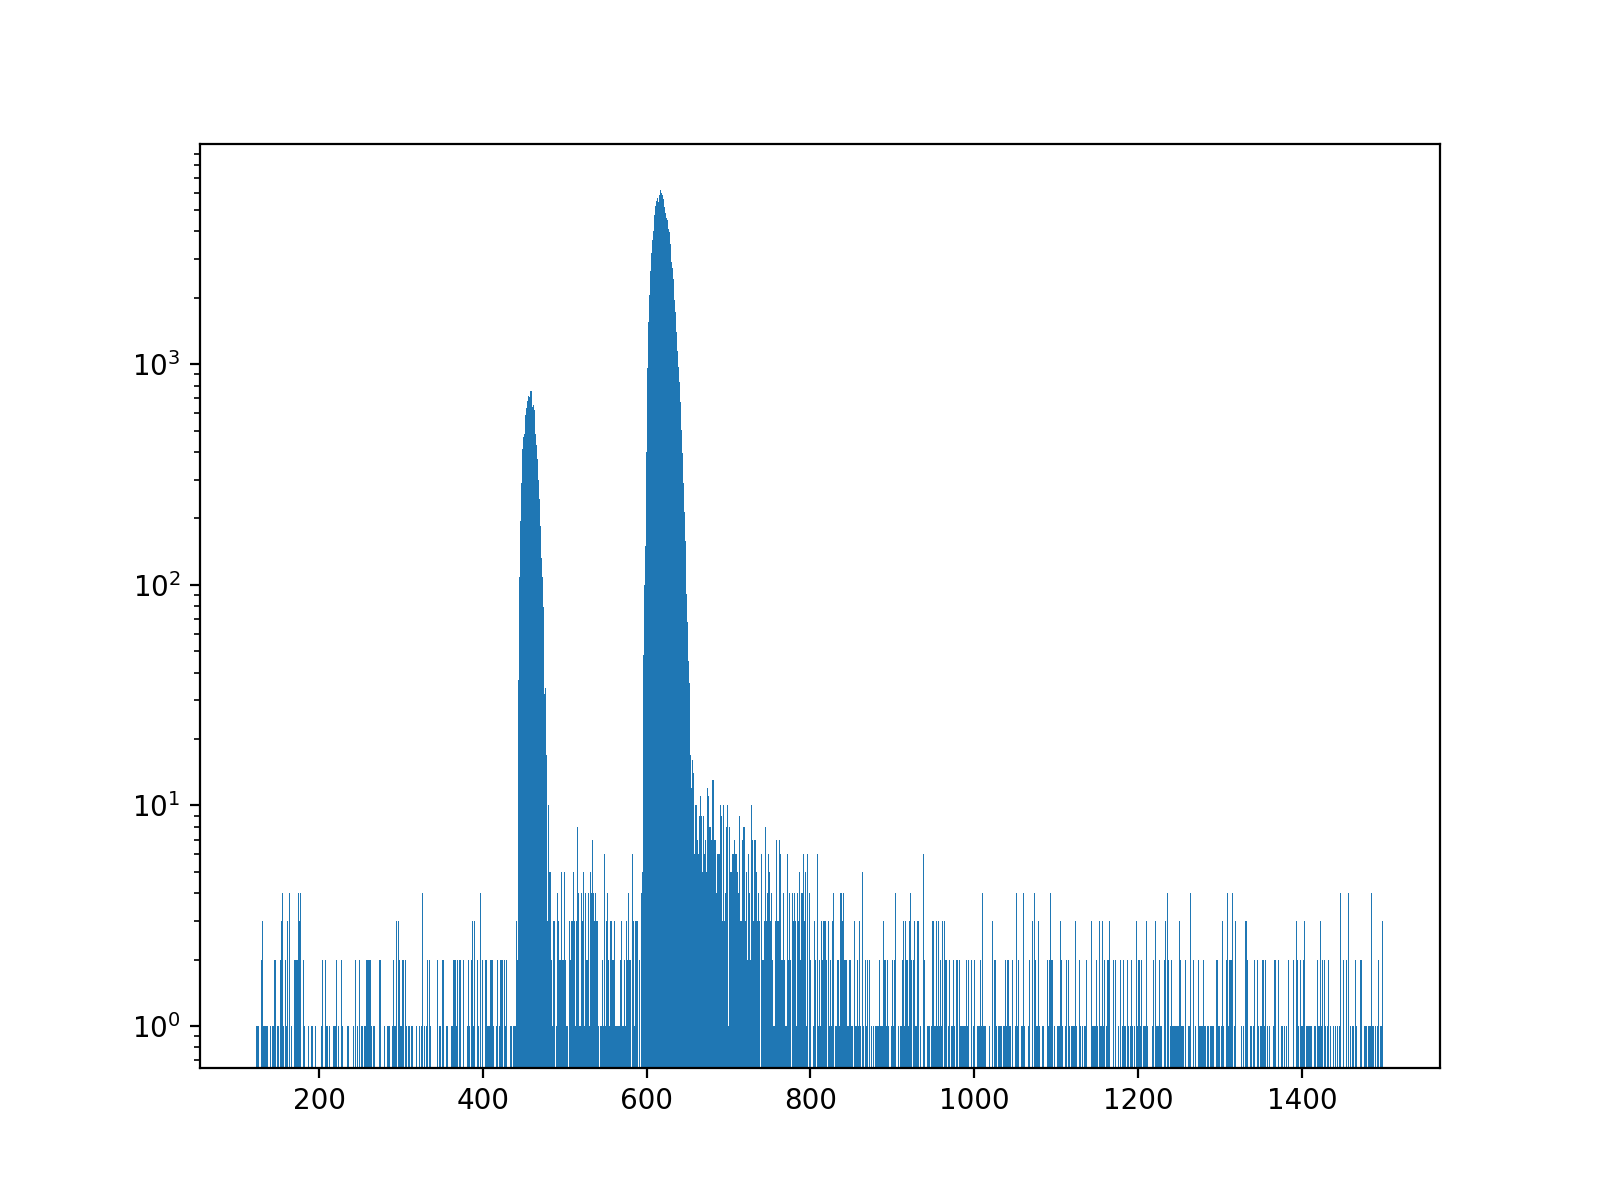

<IPython.core.display.Javascript object>


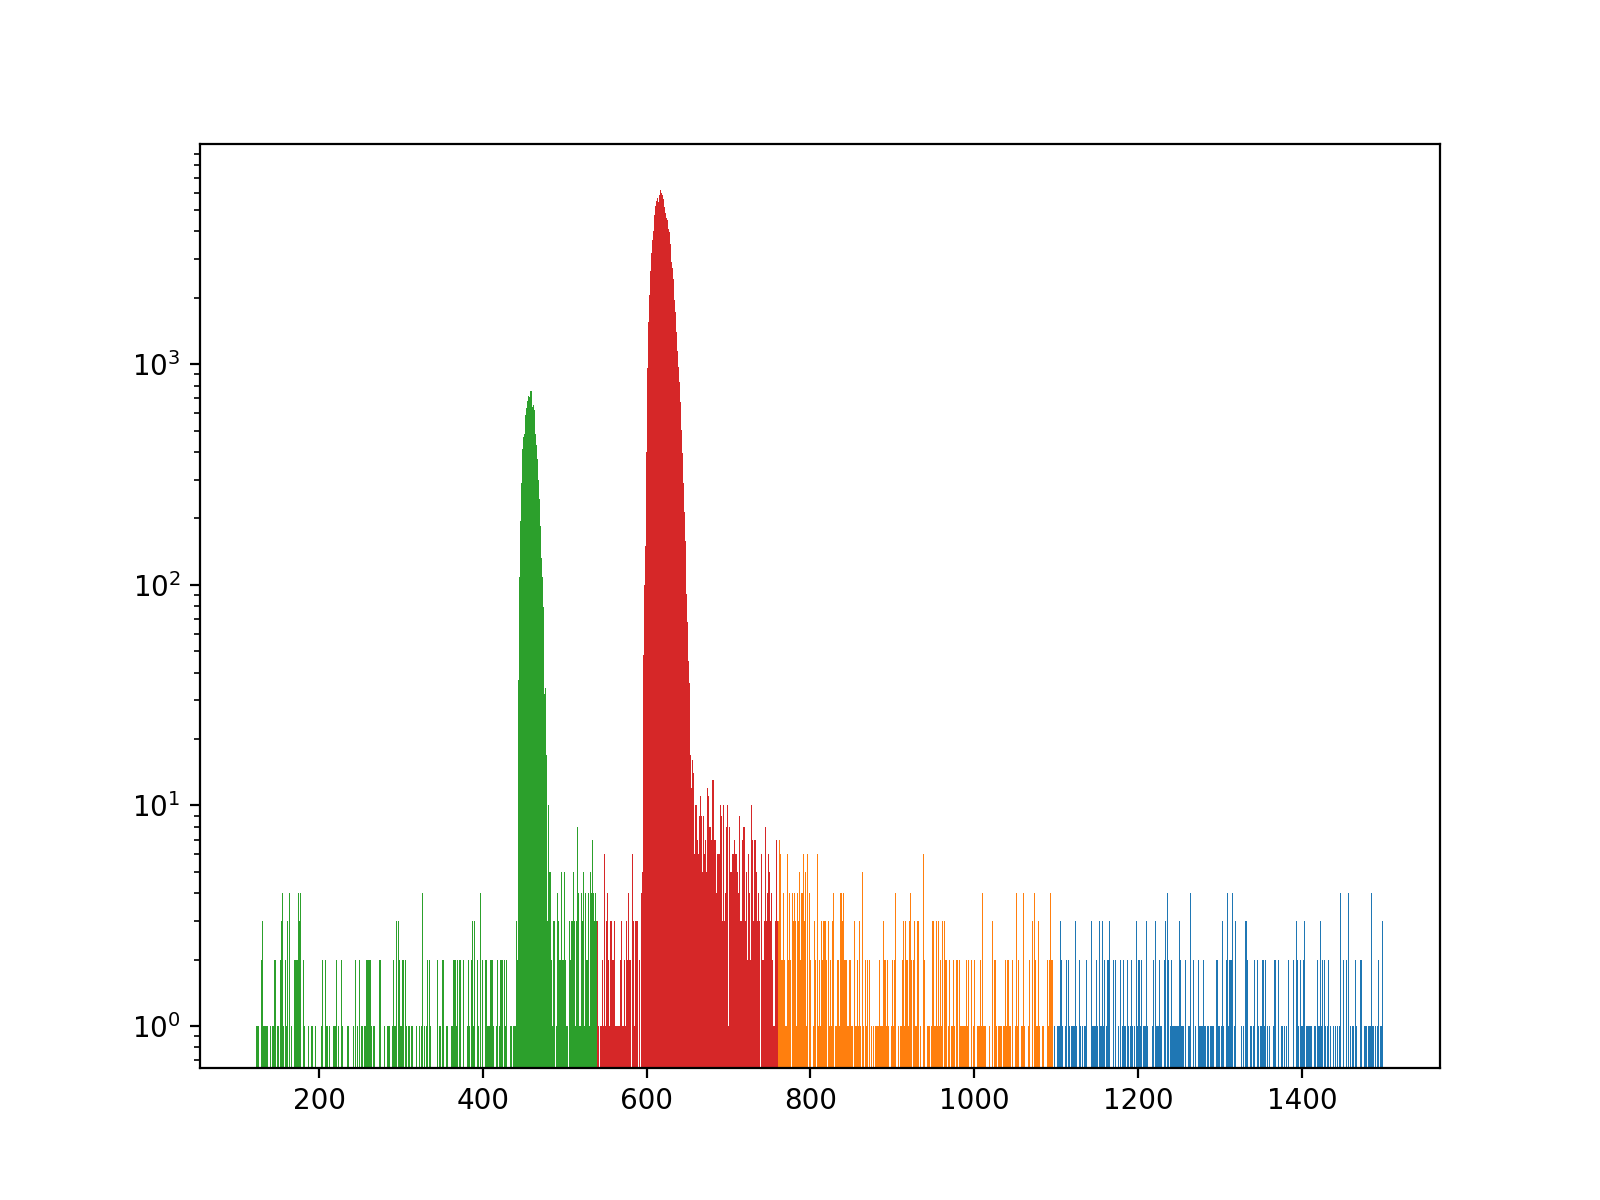

[[1297.1204 ]
 [ 898.37103]
 [ 455.1562 ]
 [ 623.43335]]


In [9]:
# K-means

tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)
bins = 0.1
num_k = 4
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))
fig1, ax1 = plt.subplots(figsize=(8, 6))
plt.hist(tt, bins, log=True)
plt.show()


# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_RANDOM_CENTERS
# Apply KMeans
compactness,labels,centers = cv2.kmeans(tt , num_k, None, criteria,10,flags)

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(num_k):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.hist(centers,bins, color='black')
plt.show()
print(centers)

<IPython.core.display.Javascript object>


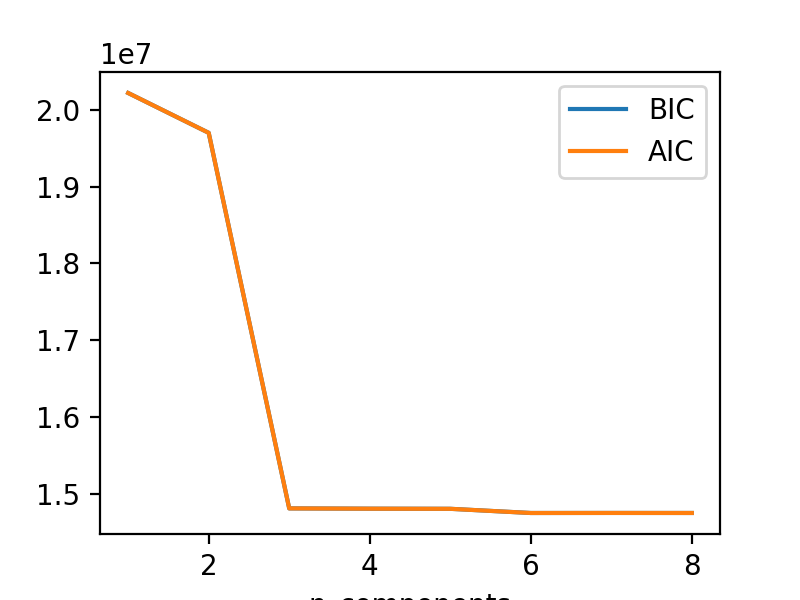

In [47]:
# GMM number of componnents
from sklearn import mixture
tt = np.copy(dld_t[dld_t < lim_dld_t])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)

n_components = np.arange(1, 9)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(tt)
          for n in n_components]

fig1, ax1 = plt.subplots(figsize=(4, 3))
bic_test = [m.bic(tt) for m in models]
aic_test = [m.aic(tt) for m in models]
plt.plot(n_components, bic_test, label='BIC')
plt.plot(n_components, aic_test, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.show()

In [ ]:
n_components = min(np.argmin(bic_test), np.argmin(aic_test))

<IPython.core.display.Javascript object>


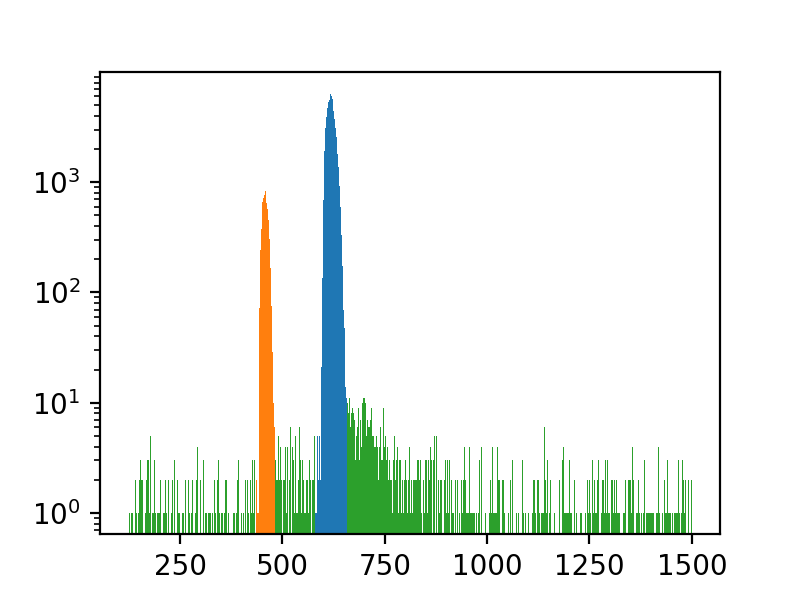

In [49]:

tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)

# n_components = 7
bins = 0.1
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))

gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(tt)
labels = gmm.predict(tt)


fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(n_components):
    A = tt[labels==i]
    plt.hist(A, bins, log=True)
plt.show()

<IPython.core.display.Javascript object>


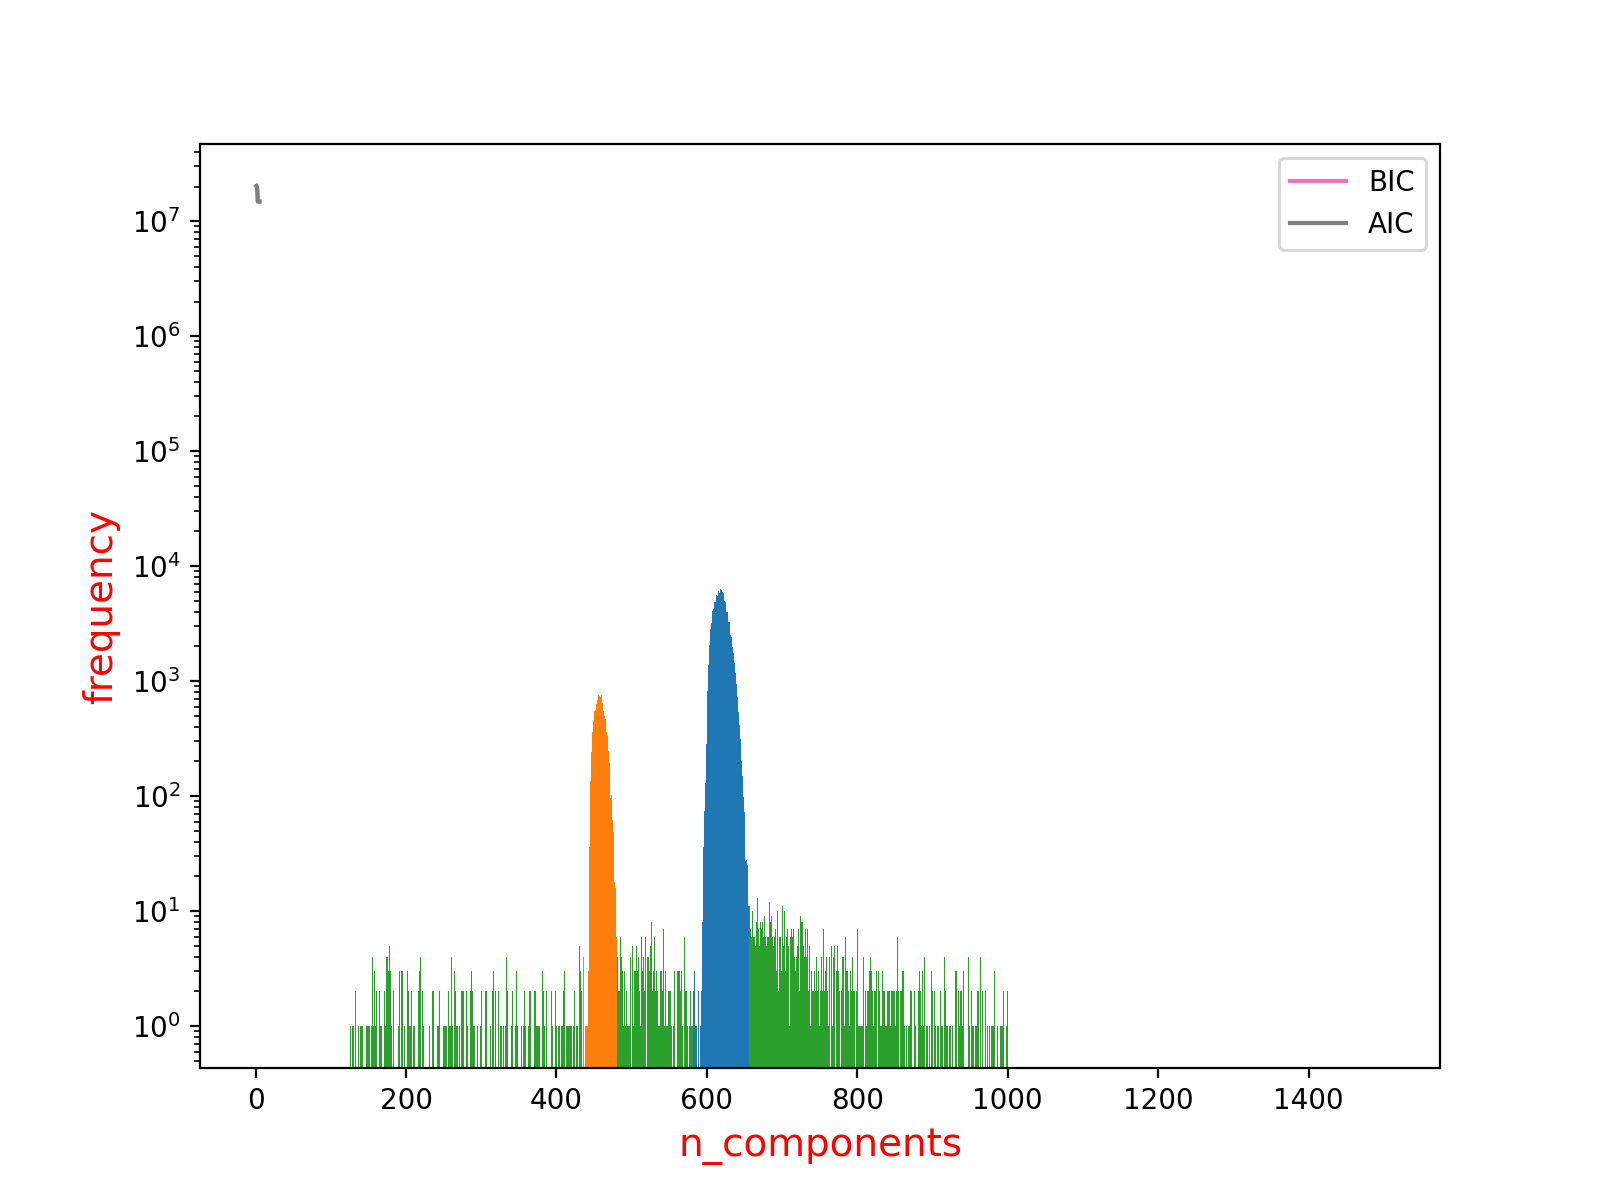

In [28]:

tt = np.copy(dld_t[dld_t < 1500])
tt = np.expand_dims(tt, axis=1)
tt = np.float32(tt)

# n_components = 7
bins = 0.1
bins = np.linspace(np.min(tt), np.max(tt), round(np.max(tt) / bins))

gmm = mixture.GaussianMixture(n_components=n_components, covariance_type='full').fit(tt)
labels = gmm.predict(tt)

fig1, ax1 = plt.subplots(figsize=(8, 6))
for i in range(n_components):
    A = tt[labels==i]
    # Get histogram
    hist, bins = np.histogram(A, bins=bins)

    # Threshold frequency
    freq = 5

    # Zero out low values
    hist[np.where(hist <= freq)] = 0
    # Plot
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
plt.title("Gaussian Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
ax1.set_yscale('log')
#     plt.hist(A, bins, log=True)
plt.show()